**Tech Challenge - Fase 1 - Grupo 19**

*Previsão de custos de seguro saúde*

1 - Base de Dados

In [143]:
import pandas as pd
dataset = pd.read_csv("archive/insurance.csv")

dataset.head()


,idade,gênero,imc,filhos,fumante,região,encargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [144]:
dataset["região"].value_counts()

região
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [145]:
dataset.describe()

,idade,imc,filhos,encargos
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [146]:
import matplotlib as mpl
import matplotlib.pyplot as plt

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

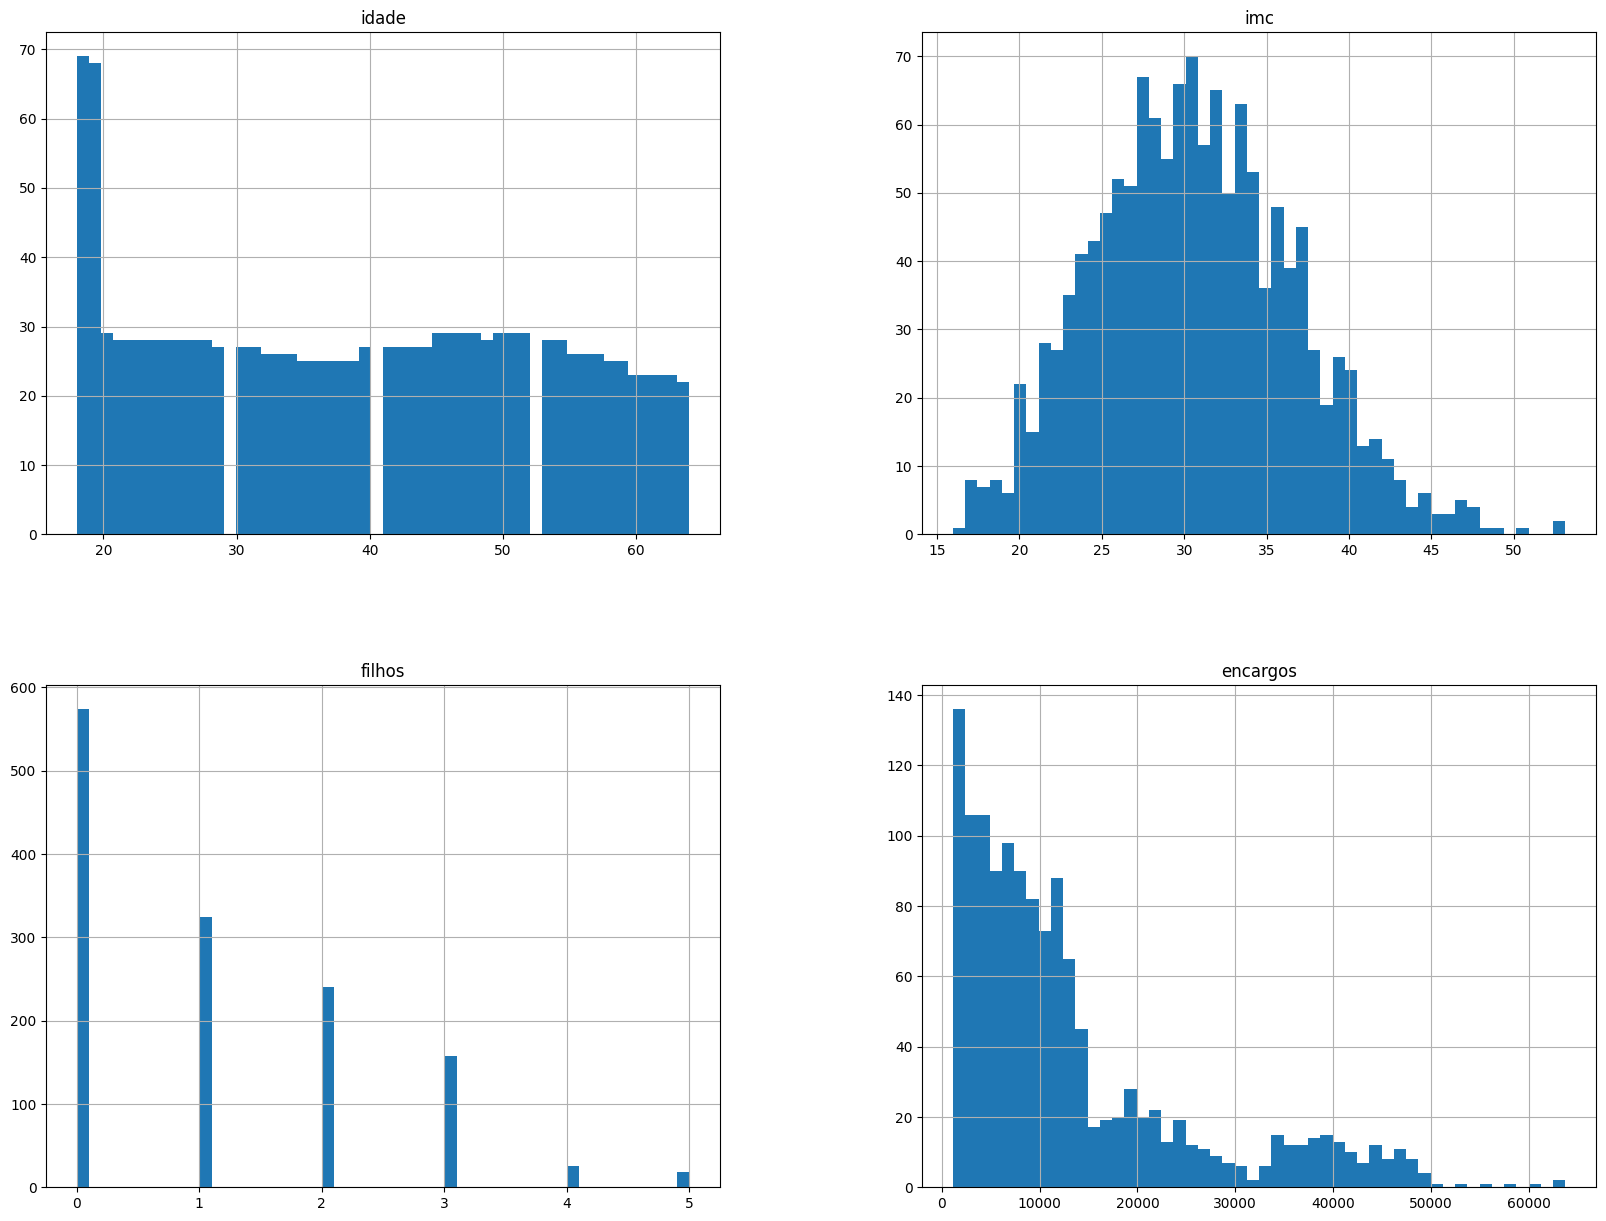

In [147]:
dataset.hist(bins=50, figsize=(20,15))

- Transformar IMC e idade em categorias

In [148]:
import numpy as np
np.random.seed(42)

dataset["faixas_imc"] = pd.cut(dataset["imc"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

dataset["faixas_imc"].value_counts()


faixas_imc
4    397
3    380
5    226
2    221
6     93
1     21
Name: count, dtype: int64

- Transformar gênero, fumante e região em dados numéricos

In [149]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

dataset['genero_type'] = label_encoder.fit_transform(dataset['gênero'])
dataset['fumante_type'] = label_encoder.fit_transform(dataset['fumante'])
dataset['regiao_type'] = label_encoder.fit_transform(dataset['região'])

dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos,faixas_imc,genero_type,fumante_type,regiao_type
0,19,female,27.900,0,yes,southwest,16884.92400,3,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,4,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,4,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,2,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,3,1,0,1


In [150]:
dataset_tratado = dataset.drop(columns = [ "imc", "fumante", "região", "gênero"]).copy()

dataset_tratado.head()

,idade,filhos,encargos,faixas_imc,genero_type,fumante_type,regiao_type
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


In [151]:
#Separar treino e teste garantindo que ambas tem a mesma proporção de faixas de imc
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset_tratado, dataset_tratado["faixas_imc"]):
    strat_train_set = dataset_tratado.loc[train_index]
    strat_test_set = dataset_tratado.loc[test_index]

In [152]:
# Analisando as proporções
strat_test_set["faixas_imc"].value_counts() / len(strat_test_set)

faixas_imc
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64

In [153]:
# Analisando as proporções
strat_train_set["faixas_imc"].value_counts() / len(strat_train_set)

faixas_imc
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64

**Correlações**

In [154]:
corr_matrix = dataset_tratado.corr()
corr_matrix["encargos"].sort_values(ascending=False)

encargos        1.000000
fumante_type    0.787251
idade           0.299008
faixas_imc      0.205401
filhos          0.067998
genero_type     0.057292
regiao_type    -0.006208
Name: encargos, dtype: float64

**Separar encargos esperados e remover do dataset de treino**

In [155]:
X_train = strat_train_set.copy()
y_train = X_train["encargos"].copy()     

X_train = X_train.drop(columns=['encargos'], axis=1)

X_test = strat_test_set.copy()
y_test = X_test["encargos"].copy()

X_test = X_test.drop(columns=['encargos'], axis=1)


**Criando funções para execução e avaliação de cada modelo**

In [202]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def evaluate_model(y_test, predictions):
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions)
    errors = np.abs(y_test - predictions)
    relative_errors = errors / np.abs(y_test)
    mape = np.mean(relative_errors) * 100
    print("Mean Squared Error:", mse)
    print("Root Mean Squared Error:", rmse)
    print('r²', r2)
    print(f"O MAPE é: {mape:.2f}%")

     # Visualizando as previsões

    plt.scatter(range(len(y_test)), y_test, color='blue')
    plt.scatter(range(len(predictions)), predictions, color='red')
    #plt.show() 

    #y_test_array = y_test.to_numpy()
   
    #plt.plot(y_test_array)
    #plt.plot(predictions, color='red')

    

    plt.ylabel('Custo Médico')
    plt.title('Previsto vs Real')
    plt.legend(['Real', 'Previsto'])


def run_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print()
    print(model)
    evaluate_model(y_test, predictions)

**Testando LinearRegression**

**Testando LinearRegression**


LinearRegression()
Mean Squared Error: 37701216.76527436
Root Mean Squared Error: 6140.1316569984365
r² 0.7500491276747095
O MAPE é: 42.22%


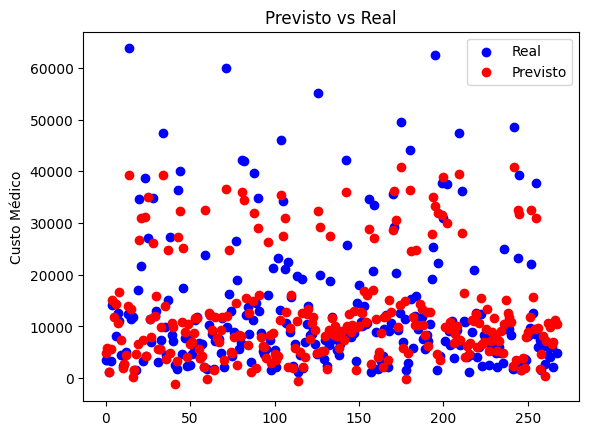

In [203]:
from sklearn.linear_model import LinearRegression

run_model(LinearRegression(), X_train, y_train, X_test, y_test)


**Testando DecisionTreeRegressor**


DecisionTreeRegressor()
Mean Squared Error: 36194719.85843261
Root Mean Squared Error: 6016.204771983133
r² 0.7600368747112264
O MAPE é: 32.21%


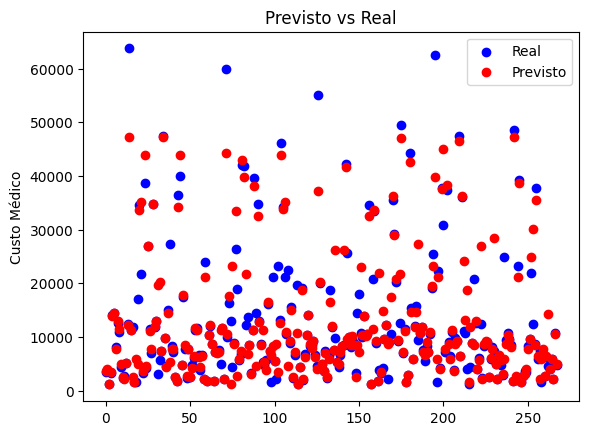

In [204]:
from sklearn.tree import DecisionTreeRegressor

run_model(DecisionTreeRegressor(), X_train, y_train, X_test, y_test)

**Testando RandomForestRegressor**



RandomForestRegressor()
Mean Squared Error: 24370768.433374163
Root Mean Squared Error: 4936.675848521368
r² 0.838427102576428
O MAPE é: 35.96%


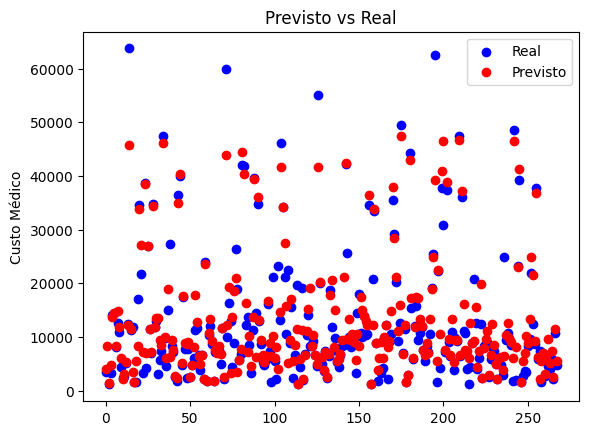

In [205]:
from sklearn.ensemble import RandomForestRegressor

run_model(RandomForestRegressor(), X_train, y_train, X_test, y_test)    

**Testando GradientBoostingRegressor**


GradientBoostingRegressor()
Mean Squared Error: 18999475.40668914
Root Mean Squared Error: 4358.838768145611
r² 0.8740376078259899
O MAPE é: 29.38%


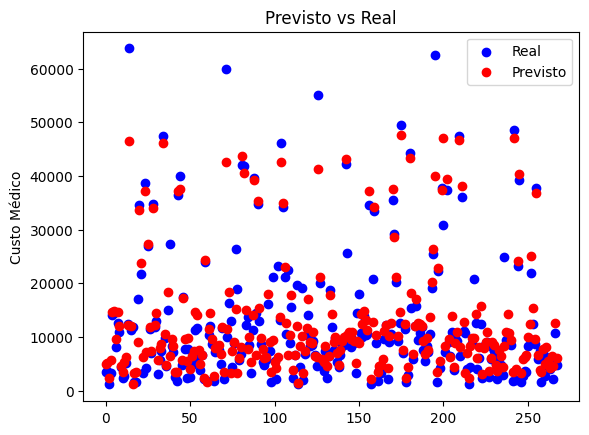

In [206]:
from sklearn.ensemble import GradientBoostingRegressor

run_model(GradientBoostingRegressor(), X_train, y_train, X_test, y_test)  

O valor maximo de encargos está muito acima da média 63770.42 x 13270.42

Vamos tentar remover da amostra valores que o 75th percentil da base 16639.91

In [207]:
def recuperar_valor_quartil(data, quartil):
    """
    Calcula o valor do quartil especificado para os dados fornecidos.

    Parâmetros:
        data (array): Array contendo os dados.
        quartil (int): Número do quartil desejado (25, 50 ou 75).

    Retorna:
        float: Valor do quartil especificado.
    """
    return np.percentile(data, quartil)

Q3 = recuperar_valor_quartil(dataset_tratado['encargos'], 75)
print("Q3:", Q3)

dataset_ajustado = dataset_tratado[dataset_tratado['encargos'] <= Q3]

dataset_ajustado.reset_index(drop=True, inplace=True)

for train_index, test_index in split.split(dataset_ajustado, dataset_ajustado["faixas_imc"]):
    strat_train_set_a = dataset_ajustado.loc[train_index]
    strat_test_set_a = dataset_ajustado.loc[test_index]

X_train_a = strat_train_set_a.copy()
y_train_a = X_train_a["encargos"].copy()

X_train_a = X_train_a.drop(columns=['encargos'], axis=1)

X_test_a = strat_test_set_a.copy()
y_test_a = X_test_a["encargos"].copy()

X_test_a = X_test_a.drop(columns=['encargos'], axis=1)

In [200]:
y_test_a.describe()

count      201.000000
mean      7239.516578
std       4142.252794
min       1136.399400
25%       3594.170850
50%       6710.191900
75%      10704.470000
max      16577.779500
Name: encargos, dtype: float64

**Testando novamente LinearRegression**


LinearRegression()
Mean Squared Error: 2320769.254071569
Root Mean Squared Error: 1523.4071202641692
r² 0.8640670240834455
O MAPE é: 11.77%


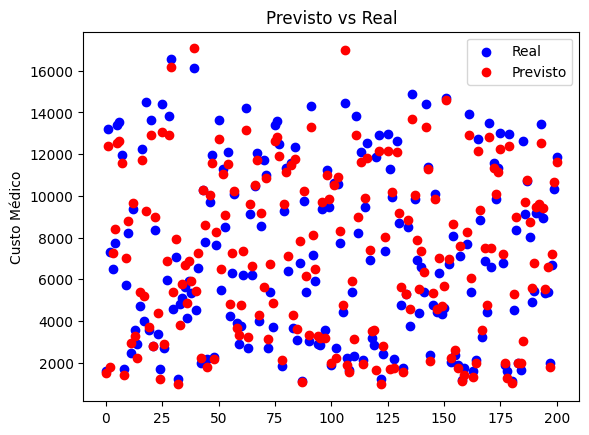

In [208]:

run_model(LinearRegression(), X_train_a, y_train_a, X_test_a, y_test_a)

**Testando novamente DecisionTree**


DecisionTreeRegressor()
Mean Squared Error: 2725746.3785575773
Root Mean Squared Error: 1650.9834579902904
r² 0.8403465505323018
O MAPE é: 11.11%


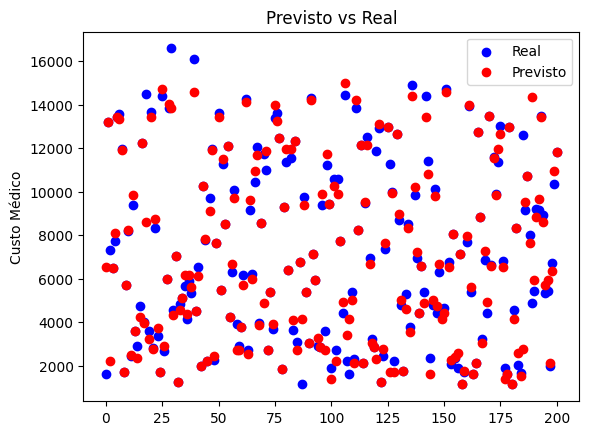

In [209]:
run_model(DecisionTreeRegressor(), X_train_a, y_train_a, X_test_a, y_test_a)

**Testando novamente RandomForrestRegressor**


RandomForestRegressor()
Mean Squared Error: 2104932.5892479513
Root Mean Squared Error: 1450.838581389381
r² 0.8767090909799735
O MAPE é: 10.91%


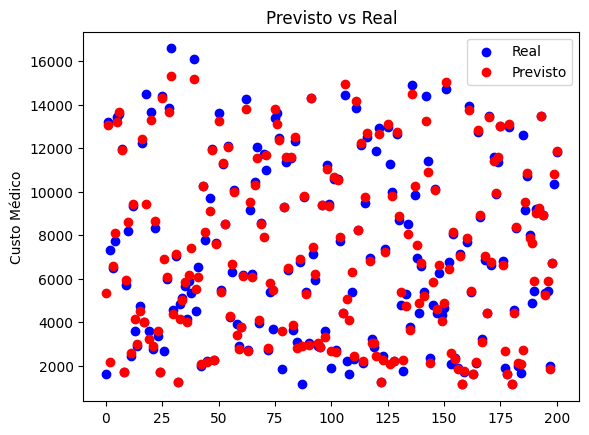

In [210]:
run_model(RandomForestRegressor(), X_train_a, y_train_a, X_test_a, y_test_a)    

**Testando novamente GradientBoostingRegressor**


GradientBoostingRegressor()
Mean Squared Error: 2058558.4790142982
Root Mean Squared Error: 1434.7677439273223
r² 0.8794253329322845
O MAPE é: 11.11%


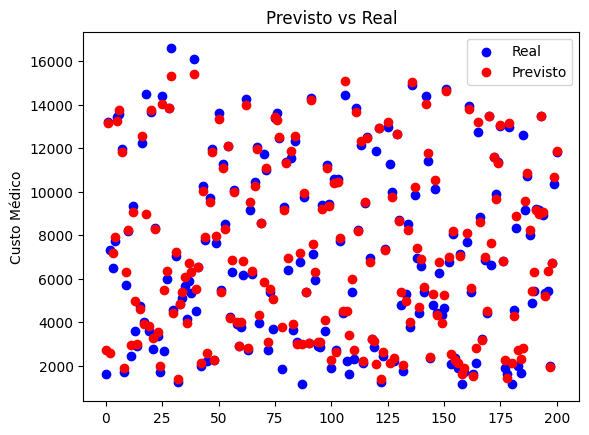

In [211]:
run_model(GradientBoostingRegressor(), X_train_a, y_train_a, X_test_a, y_test_a)